<span style="color:red; font-size:200%;">Partie 2: Modeles de prévision de la consommation d'énergie </span>

# Import des bibliotheques necessaires

In [200]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
import time

# Import des données

In [201]:
data=pd.read_csv('data_Energy_Final.csv')

In [202]:
data.shape

(1456, 16)

In [203]:
data.columns

Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)',
       'Proportion_surface_parking', 'Proportion_surface_second',
       'distance_ville_batiment', 'BuildingType_Campus',
       'PrimaryPropertyType_Hospital', 'Neighborhood_EAST',
       'LargestPropertyUseType_Hotel', 'SecondLargestPropertyUseType_Other',
       'SiteEnergyUseWN(kBtu)'],
      dtype='object')

# Train test Split

Commençons par la répartition de notre jeu de données en des données d'entrainement et de test, aussi on va faire la stratification de notre jeu de donnés car en stratifiant les données lors de la division en ensembles d'entraînement et de test, on s'assure que chaque classe est représentée de manière proportionnelle dans les deux ensembles. Cela contribue à minimiser les risques de biais liés à la distribution des classes et à améliorer la validité des résultats lors de l'évaluation du modèle.

In [206]:
data=data[data['SiteEnergyUseWN(kBtu)']>0]
data['quantile_labels'] = pd.qcut(data['SiteEUIWN(kBtu/sf)'], q=[0,0.25, 0.5, 0.75, 1.0], labels=False)
data=data.drop('SiteEUIWN(kBtu/sf)',axis=1)

X=data.drop(['SiteEnergyUseWN(kBtu)'],axis=1)
y=data['SiteEnergyUseWN(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=10,
    stratify=data['quantile_labels']  
)

In [207]:
X_test = X_test.drop('quantile_labels',axis=1)

# Les Fonctions 

On présente ci-dessous toutes fonctions utilisées lors de notre prévision commençons par le traçage de residus et la distributions,ensuite fonction pour entrainer notre modeles et choisir les meilleurs hyperparametres,aprés les fonctions de feature importance.

In [208]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, residuals, alpha=0.5)
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Résidus (Real Price - Predicted Price)')
    plt.title('Graphique des résidus')
    plt.axhline(y=0, color='red', linestyle='--')  
    plt.show()

In [209]:
def plot_residuals_and_distribution(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, bins=30, kde=True, color='blue')
    plt.xlabel('Résidus (Real Price - Predicted Price)')
    plt.ylabel('Fréquence')
    plt.title('Distribution des résidus')
    plt.tight_layout()
    plt.show()

In [210]:
def hyperparameter_Fonction(pipline,param_grid,model_name,X_train, y_train, X_test, y_test):
    start_time = time.time()  
    
    random_search=RandomizedSearchCV(pipeline, param_distributions = param_grid, n_iter =10, cv =10,scoring='r2')
    quantile_labels_train = X_train['quantile_labels'].copy()
    XX_train = X_train.drop('quantile_labels',axis=1)
    
    if model_name in ['randomforest','GradientBoosting']:
        y_train=np.log(y_train)
        y_test=np.log(y_test)
        
    random_search.fit(XX_train, y_train,groups=quantile_labels_train)

    print(f"Meilleurs paramètres: {random_search.best_params_}")

    y_train_pred = random_search.predict(XX_train)
    y_test_pred = random_search.predict(X_test)

    r2_train = random_search.score(XX_train,y_train)
    r2_test = random_search.score(X_test,y_test)
    
    fit_duration = time.time() - start_time  
    cv_scores = cross_val_score(random_search.best_estimator_, XX_train, y_train, cv=10, scoring='r2')
    r2_cv_mean = random_search.best_score_
    print(f"R2-score (Entraînement): {r2_train:.4f}")
    print(f"R2-score (Test): {r2_test:.4f}")
    print(f"R2-score (Validation croisée): {r2_cv_mean:.4f}")
    print("-" * 50)
    plot_residuals(y_test, y_test_pred)
    plot_residuals_and_distribution(y_test, y_test_pred)
    results = {
        'Model': model_name,
        'Best_Params': [random_search.best_params_],
        'R2_Train': [r2_train],
        'R2_Test': [r2_test],
        'R2_CV_Mean': [r2_cv_mean],
        'Fit_Duration': [fit_duration]
    }
    return random_search,results 

In [211]:
def plot_feature_importance(best_model, feature_names):
    coefficients = best_model[-1].coef_
    sorted_indices = np.argsort(np.abs(coefficients))
    sorted_coefficients = coefficients[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance - Global')
    plt.show()

In [212]:
#Importance Globale pour RandomForest
def plot_feature_importance_random(best_model, feature_names):
    last_step = best_model[-1]
    importances = last_step.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_feature_names = np.array(feature_names)[sorted_indices]
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_feature_names)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Importance Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance - Global')
    plt.show()

In [213]:
all_results_list = []

# Modeles de prévision

## Regression lineaire

### Définition

La régression linéaire est une technique statistique visant à modéliser la relation linéaire entre une variable dépendante (Y) et une ou plusieurs variables indépendantes (X). Elle suppose que cette relation peut être représentée par une équation linéaire. L'équation de régression linéaire prend la forme : **Y = β₀ + β₁X₁ + β₂X₂ + ... + βₖXₖ + ε, où β₀, β₁, β₂, ..., βₖ sont les coefficients de régression, X₁, X₂, ..., Xₖ** sont les variables indépendantes, et ε est le terme d'erreur. L'objectif est d'estimer ces coefficients de manière à minimiser la somme des carrés des résidus. Une fois le modèle ajusté, il peut être utilisé pour prédire la variable dépendante en fonction des valeurs des variables indépendantes.

### Le coefficient de détermination(R²)

Pour mesurer la qualité des prévisions de toutes nos modeles de prévision on a utiliser le R2 score :


In [214]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])
param_grid = {}  

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Meilleurs paramètres: {}
R2-score (Entraînement): 0.7442
R2-score (Test): 0.6567
R2-score (Validation croisée): 0.6903
--------------------------------------------------


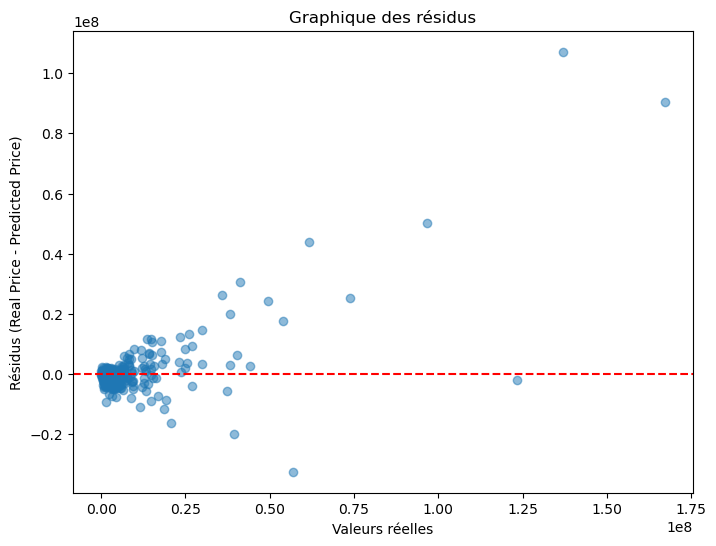

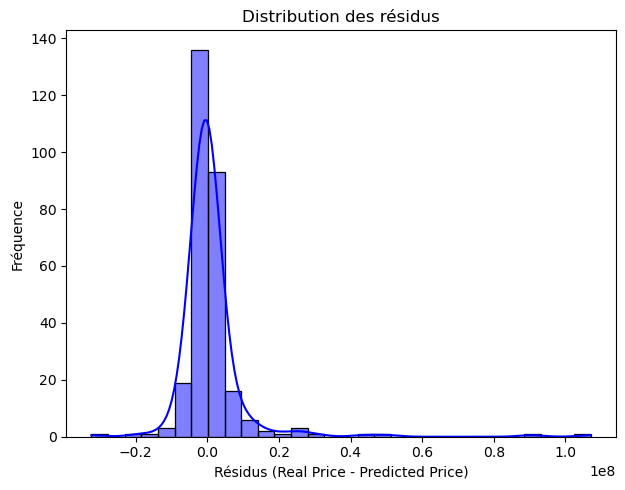

In [215]:
random_search_reg, results_reg = hyperparameter_Fonction(pipeline, param_grid, 'regression',X_train, y_train, X_test, y_test)
all_results_list.append(results_reg)

En résumé, les résultats des R2-scores indiquent une performance globalement solide du modèle de régression :  
    R2-score (Entraînement): 0.7442 - Le modèle explique environ 74.42% de la variance dans les données d'entraînement, montrant une bonne adaptation.  
    R2-score (Test): 0.6567 - Le modèle généralise raisonnablement bien aux données de test, expliquant environ 65.67% de la variance.  
    R2-score (Validation croisée): 0.6903 - La stabilité du modèle est démontrée par une performance cohérente sur différentes partitions des données, avec environ 69.03% de la variance expliquée en moyenne.


Pour s'assurer de notre modeles on a tracé la distribution des résidus,elle est centrée autour de zéro suggère que le modèle ne commet pas de biais systématique dans ses prédictions.

elle est symétrique et centrée sur zéro, indiquant que le modèle ne présente pas de tendance à sous-estimer ou surestimer de manière systématique les valeurs.

## Ridge

La régression ridge en machine learning est une technique de régularisation qui s'applique aux modèles de régression linéaire. Elle vise à minimiser la fonction objectif, qui est la somme des carrés des résidus plus un terme de régularisation pondéré par le paramètre αα. 

In [216]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
param_grid = {
    'ridge__alpha': np.logspace(-4,4,100),
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'ridge__max_iter': range(1000, 15000),
    'ridge__tol': [0.0001,0.001,0.01, 0.1,1] 
}

Meilleurs paramètres: {'ridge__tol': 1, 'ridge__solver': 'cholesky', 'ridge__max_iter': 5825, 'ridge__alpha': 4.862601580065354}
R2-score (Entraînement): 0.7441
R2-score (Test): 0.6561
R2-score (Validation croisée): 0.6907
--------------------------------------------------


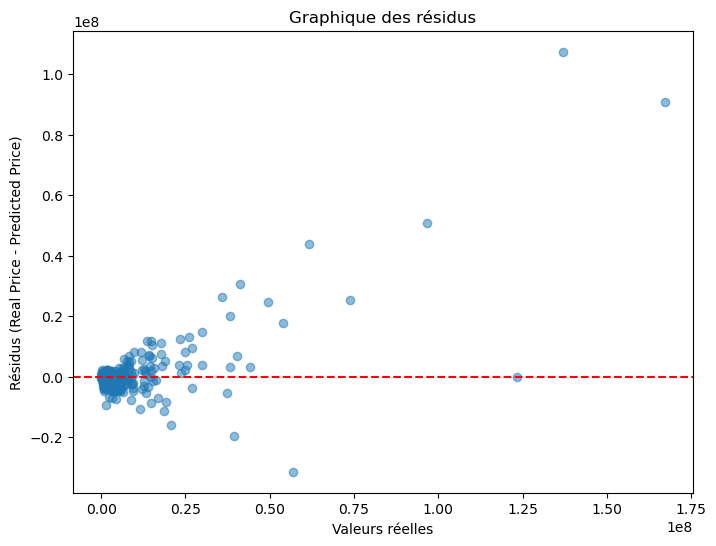

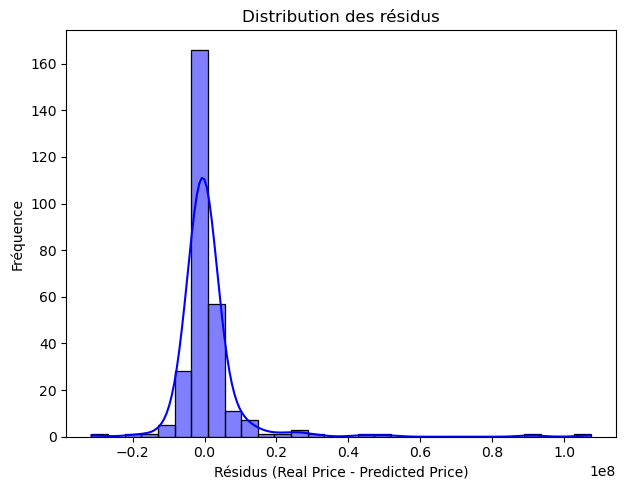

In [217]:
random_search_ridge, results_ridge = hyperparameter_Fonction(pipeline, param_grid, 'Ridge',X_train, y_train, X_test, y_test)
all_results_list.append(results_ridge)

Pour Ridge :    
R2-score (Entraînement): 0.7440 - Le modèle explique environ 74.40% de la variance dans les données d'entraînement, suggérant une adaptation satisfaisante.

R2-score (Test): 0.6555 - La capacité de généralisation aux données de test est bonne, avec environ 65.55% de la variance expliquée.

R2-score (Validation croisée): 0.6908 - La performance stable sur différentes partitions des données, évaluée par validation croisée, renforce la confiance dans la capacité du modèle à généraliser.

Ces résultats suggèrent que le modèle a une bonne capacité à expliquer la variabilité des données, tant sur les données d'entraînement que sur les nouvelles données de test.

la distribution des résidus,elle est centrée autour de zéro suggère que le modèle ne commet pas de biais systématique dans ses prédictions.

elle est symétrique et centrée sur zéro, indiquant que le modèle ne présente pas de tendance à sous-estimer ou surestimer de manière systématique les valeurs.

## Lasso

Le lasso est une méthode de régularisation qui s'applique aux modèles de régression linéaire. Son objectif est de pénaliser les coefficients des variables moins importantes en les réduisant vers zéro, ce qui permet d'obtenir un modèle plus parcimonieux (avec moins de variables explicatives).

In [218]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

param_grid = {
    'lasso__alpha':[0.001, 0.01, 0.1, 1.0,5, 10.0, 100, 1000],
    'lasso__fit_intercept': [True, False],
    'lasso__max_iter': range(400, 600),
    'lasso__tol': [0.001, 0.01, 0.1],
}

Meilleurs paramètres: {'lasso__tol': 0.01, 'lasso__max_iter': 562, 'lasso__fit_intercept': True, 'lasso__alpha': 0.1}
R2-score (Entraînement): 0.7442
R2-score (Test): 0.6567
R2-score (Validation croisée): 0.6903
--------------------------------------------------


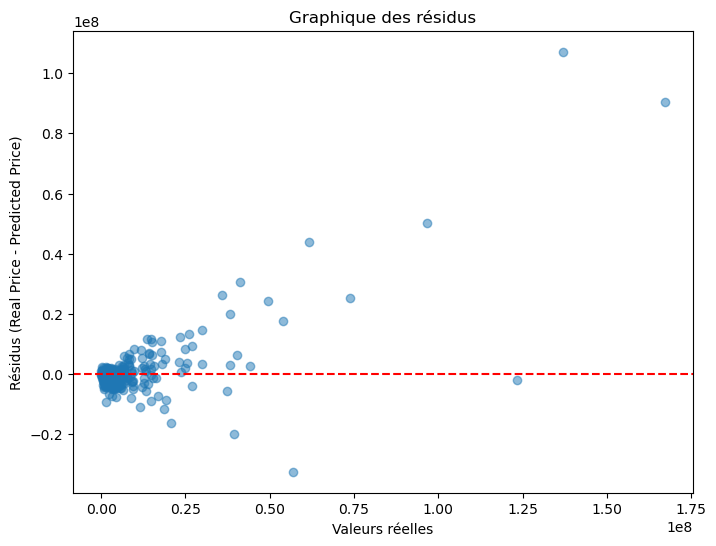

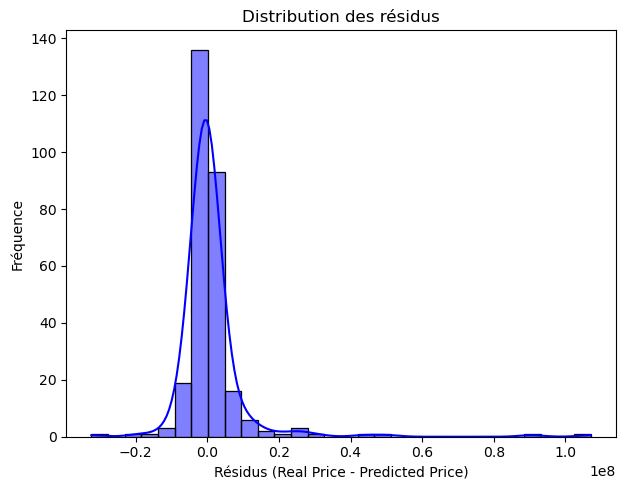

In [219]:
random_search_lasso, results_lasso = hyperparameter_Fonction(pipeline, param_grid, 'Lasso',X_train, y_train, X_test, y_test)
all_results_list.append(results_lasso)

Meme interprétation pour Lasso avec un R2-score (Entraînement): 0.7442 de Test égale à  0.6567 et de Validation croisée égale à 0.7300.

## ElasticNet

L'Elastic Net est une technique de régularisation utilisée dans les modèles de régression, combinant à la fois les pénalités L1 (lasso) et L2 (ridge). Il a été développé pour surmonter certaines limitations individuelles de ces deux méthodes. Le terme "Elastic Net" vient de la combinaison de l'élasticité de la régularisation L1 et de la régularisation quadratique L2.

In [220]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet())
])

param_grid = {
    'elasticnet__alpha': [0.1,100],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9],
    'elasticnet__fit_intercept': [True, False],
    'elasticnet__max_iter': range(200, 1000),
    'elasticnet__tol': [0.001, 0.01, 0.1],
    'elasticnet__precompute': [True, False],
    'elasticnet__copy_X': [True, False],
    'elasticnet__warm_start': [True, False],
    'elasticnet__positive': [True, False],
    'elasticnet__random_state': [None, 42]
}

Meilleurs paramètres: {'elasticnet__warm_start': False, 'elasticnet__tol': 0.01, 'elasticnet__random_state': 42, 'elasticnet__precompute': True, 'elasticnet__positive': False, 'elasticnet__max_iter': 205, 'elasticnet__l1_ratio': 0.5, 'elasticnet__fit_intercept': True, 'elasticnet__copy_X': True, 'elasticnet__alpha': 0.1}
R2-score (Entraînement): 0.7392
R2-score (Test): 0.6448
R2-score (Validation croisée): 0.6877
--------------------------------------------------


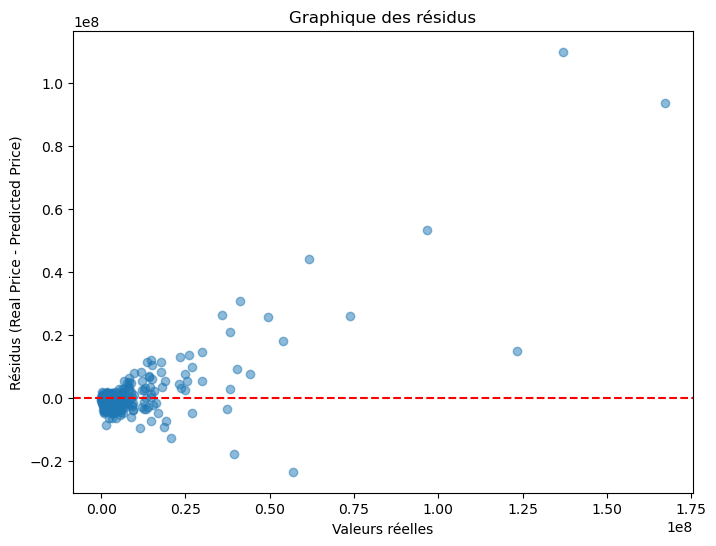

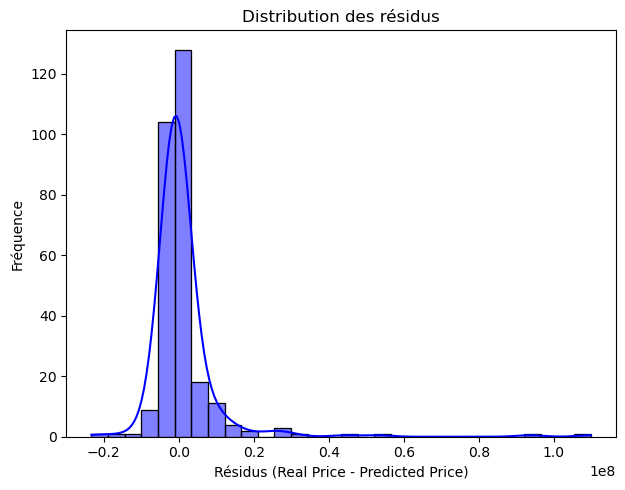

In [221]:
random_search_elastic, results_elastic = hyperparameter_Fonction(pipeline,param_grid,'elasticnet',X_train, y_train, X_test, y_test)
all_results_list.append(results_elastic)

On peut peut voir aussi que elastic net donne de bonne resultats avec un R2 score égale à  0.7392 pour Entraînement et 0.6448 pour le test 0.7255 pour validation croisée. 

## RandomForest

Random Forest est une technique d'ensemble en machine learning, qui combine les prédictions de plusieurs modèles d'arbres de décision pour améliorer la précision et la robustesse du modèle global. 

In [222]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforest', RandomForestRegressor())
])

param_grid = {
    'randomforest__n_estimators': [10,20,30,50,100,200,300,400,600],
    'randomforest__criterion': ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    'randomforest__max_depth': [2,3],
    'randomforest__max_features':[0.2,0.3,0.5,0.7,1],
    'randomforest__min_samples_split':  [12,14,16,20,24,30,35],
    'randomforest__min_samples_leaf': [4,6, 8, 10]
}

Meilleurs paramètres: {'randomforest__n_estimators': 200, 'randomforest__min_samples_split': 20, 'randomforest__min_samples_leaf': 4, 'randomforest__max_features': 0.7, 'randomforest__max_depth': 3, 'randomforest__criterion': 'poisson'}
R2-score (Entraînement): 0.6593
R2-score (Test): 0.5924
R2-score (Validation croisée): 0.6262
--------------------------------------------------


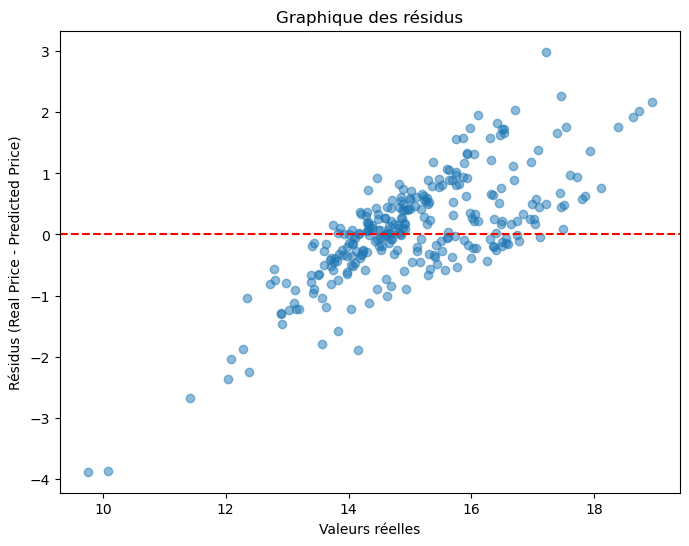

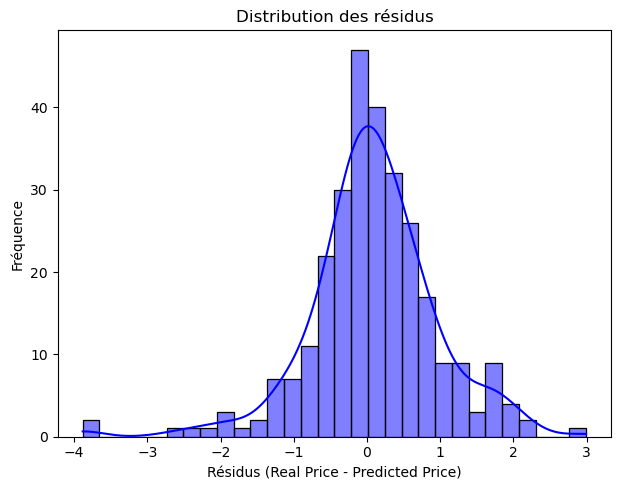

In [223]:
random_search_random, results_random = hyperparameter_Fonction(pipeline,param_grid,'randomforest', X_train, y_train, X_test, y_test)
all_results_list.append(results_random)

## GradientBoosting

Le Gradient Boosting est une technique d'ensemble (ensemble learning) utilisée en machine learning pour améliorer les performances prédictives des modèles. Le Gradient Boosting construit un modèle prédictif en combinant plusieurs modèles plus simples, généralement des arbres de décision faibles, pour former un modèle plus robuste et précis.

In [224]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('GradientBoosting', GradientBoostingRegressor())
])

param_grid = {
    'GradientBoosting__n_estimators': [10,20,30,50],
    #'GradientBoosting__learning_rate': [1.e-4,1.e-3,1.e-2,1.e-1],
    'GradientBoosting__max_depth': [2,3],
    'GradientBoosting__max_features':[0.1,0.2,0.5,0.7],
    'GradientBoosting__min_samples_split': [10,20,30],
    'GradientBoosting__min_samples_leaf':[10,15,20]
}

Meilleurs paramètres: {'GradientBoosting__n_estimators': 30, 'GradientBoosting__min_samples_split': 10, 'GradientBoosting__min_samples_leaf': 20, 'GradientBoosting__max_features': 0.7, 'GradientBoosting__max_depth': 3}
R2-score (Entraînement): 0.7445
R2-score (Test): 0.6749
R2-score (Validation croisée): 0.6916
--------------------------------------------------


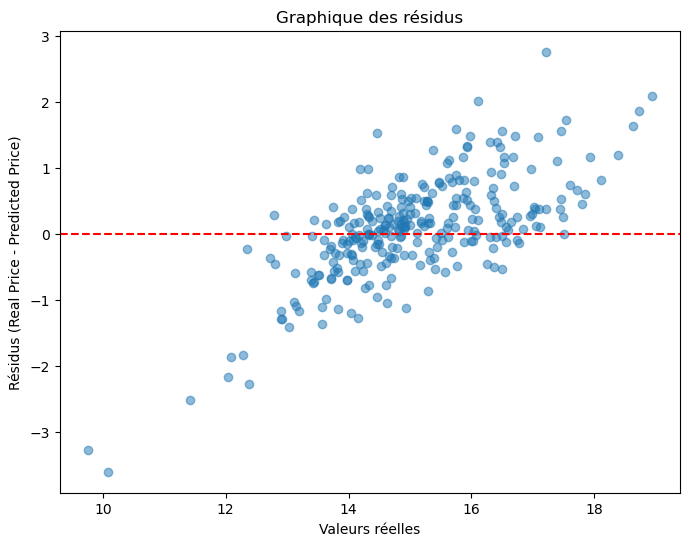

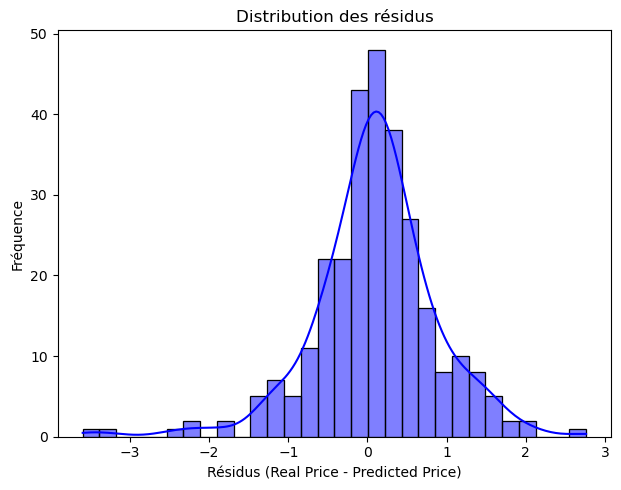

In [225]:
random_search_gradien, results_gradie = hyperparameter_Fonction(pipeline,param_grid,'GradientBoosting', X_train, y_train, X_test, y_test)
all_results_list.append(results_gradie)

L'utilisation d'un modèle ensembliste a conduit à une amélioration des résultats,avec un R2 test de 0.71 .

# Comparaison des resultats

In [234]:
all_results = pd.DataFrame(all_results_list)
all_results_sorted = all_results.sort_values(by='R2_Test',ascending=False)
all_results_sorted .head(6)

,Model,Best_Params,R2_Train,R2_Test,R2_CV_Mean,Fit_Duration
5,GradientBoosting,"[{'GradientBoosting__n_estimators': 30, 'Gradi...",[0.7444881686066813],[0.674898862849922],[0.691606850900664],[6.328878402709961]
2,Lasso,"[{'lasso__tol': 0.01, 'lasso__max_iter': 562, ...",[0.7441606661974454],[0.6567014548530852],[0.6903202660417033],[1.202000617980957]
0,regression,[{}],[0.7441606661974469],[0.656701451383306],[0.6903202609159576],[0.20000553131103516]
1,Ridge,"[{'ridge__tol': 1, 'ridge__solver': 'cholesky'...",[0.7441043534392843],[0.6560606286369335],[0.6906567353442526],[1.6195476055145264]
3,elasticnet,"[{'elasticnet__warm_start': False, 'elasticnet...",[0.7391571835009767],[0.6448014308325691],[0.687720758706611],[1.4349873065948486]
4,randomforest,"[{'randomforest__n_estimators': 200, 'randomfo...",[0.6593432804116697],[0.5924472772439717],[0.6261909471618735],[76.26163387298584]


# Feature importance

## Linear_regression

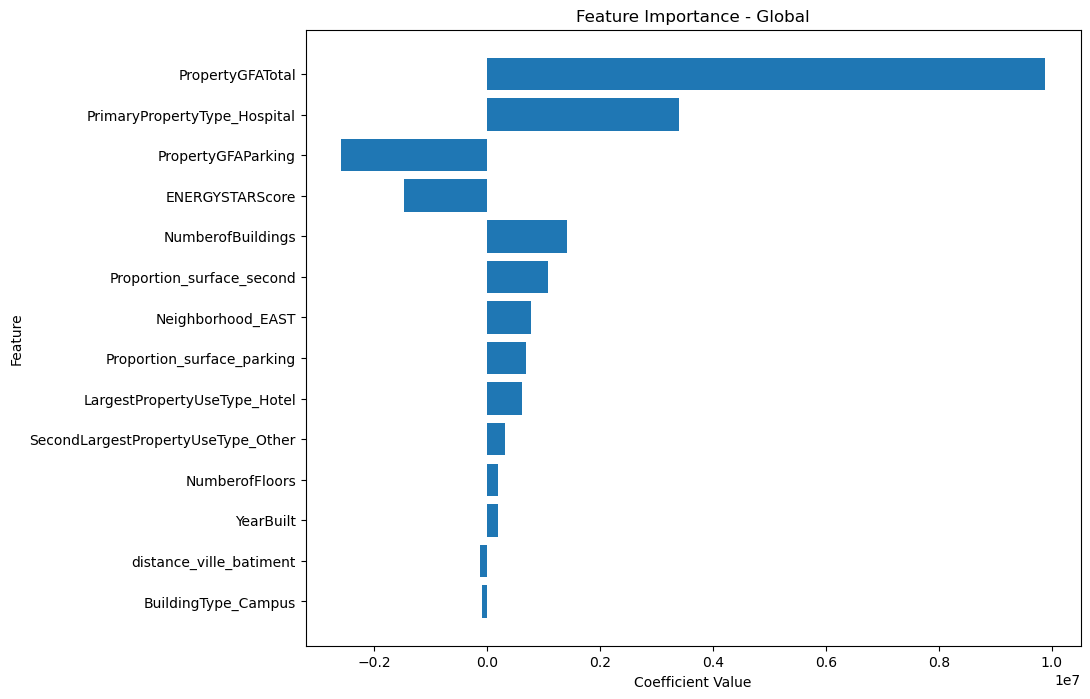

In [227]:
best_params = random_search_reg.best_params_
best_model = random_search_reg.best_estimator_
feature_names = X_train.columns

plot_feature_importance(best_model, feature_names)

Dans ce graphe, la caractéristique "Surface Total" apparaîts avec la plus grande barre, indiquant une importance élevée. Cela suggère que la Surface des Batiments  est le facteur le plus influent dans la prédiction de la consomation d'energie. Les autres caractéristiques, comme Primary proprety type et nombre de batiment ,indique leur contribution relative à la prise de décision du modèle. En interprétant ce graphe, nous pourrions conclure que, selon notre modèle, la taille d'un batiment est le paramètre déterminant dans la consommation d'energie.

## Ridge

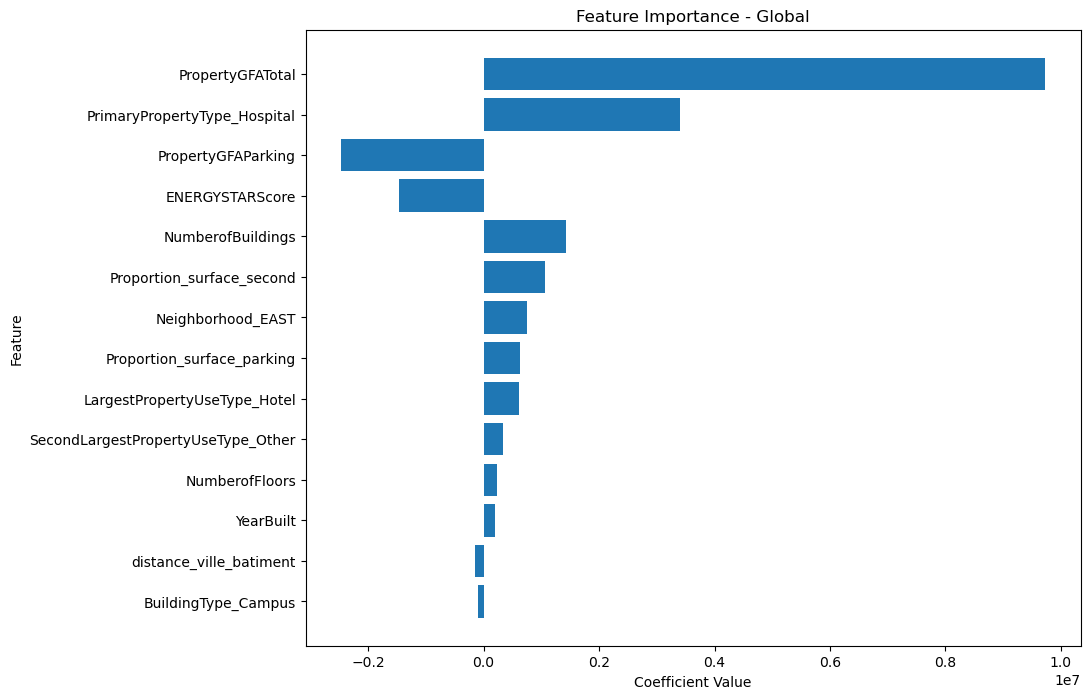

In [228]:
best_params1 = random_search_ridge.best_params_
best_model1 = random_search_ridge.best_estimator_
plot_feature_importance(best_model1, feature_names)

Meme interprétation pour Ridge.

# Feature_Importance_Local

Ici, pour le Feature Importance Local j'ai choisi le modele qui a donnée les meilleur resultat le gradienboosting.

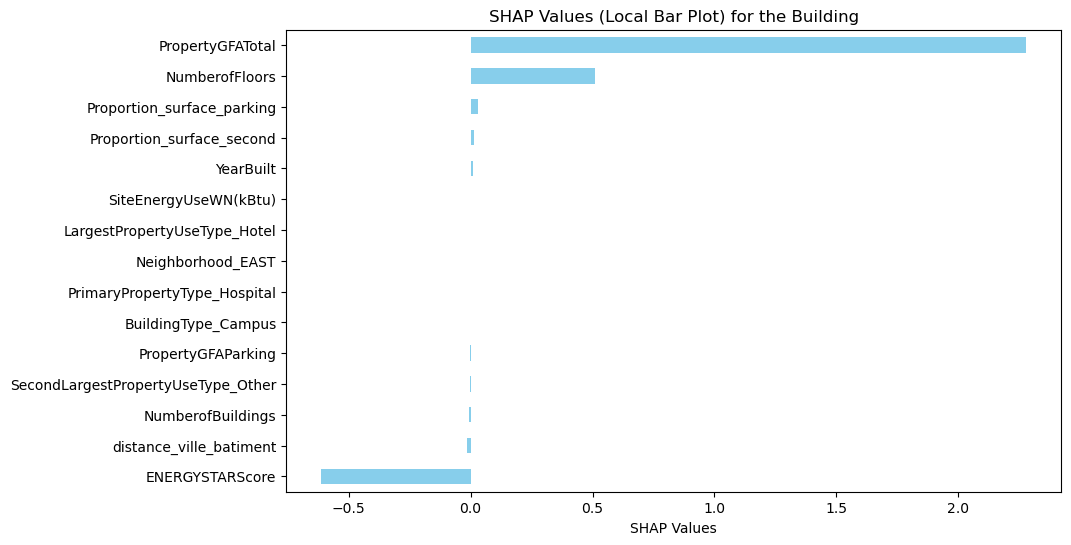

In [229]:
#GradienBoosting
import shap
best_estimator = random_search_gradien.best_estimator_
data=data.drop('quantile_labels',axis=1)
X_building = data.iloc[[0]]
explainer = shap.TreeExplainer(best_estimator.named_steps['GradientBoosting'])
shap_values_building = explainer.shap_values(X_building)
feature_names = X_building.columns
shap_values_building = pd.Series(shap_values_building[0], index=feature_names)
shap_values_building = shap_values_building.sort_values()
plt.figure(figsize=(10, 6))
shap_values_building.plot(kind='barh', color='skyblue')
plt.xlabel('SHAP Values')
plt.title('SHAP Values (Local Bar Plot) for the Building')
plt.show()

In [235]:
X_building = data.iloc[[0]]
print(X_building)

   YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0     1927.0                1.0            12.0           88434.0   

   PropertyGFAParking  Proportion_surface_parking  Proportion_surface_second  \
0                 0.0                         0.0                   0.221245   

   distance_ville_batiment  BuildingType_Campus  PrimaryPropertyType_Hospital  \
0                 0.801048                    0                             0   

   Neighborhood_EAST  LargestPropertyUseType_Hotel  \
0                  0                             1   

   SecondLargestPropertyUseType_Other  SiteEnergyUseWN(kBtu)  
0                                   0              7456910.0  


Pour le batiment qui a les caractériqtique ci-dessus on peut constater que la surface de batiment a joué un rôle crucial dans la prédiction de son consommation d'energie. Une augmentation significative du surface pour ce batiment est fortement associée à une prédiction de consommation plus élevé, selon le modèle."

# Interet de Energystar

In [236]:
data=data.drop('ENERGYSTARScore',axis=1)

KeyError: "['ENERGYSTARScore'] not found in axis"

Meilleurs paramètres: {'GradientBoosting__n_estimators': 30, 'GradientBoosting__min_samples_split': 10, 'GradientBoosting__min_samples_leaf': 10, 'GradientBoosting__max_features': 0.5, 'GradientBoosting__max_depth': 3}
R2-score (Entraînement): 0.7428
R2-score (Test): 0.6704
R2-score (Validation croisée): 0.6829
--------------------------------------------------


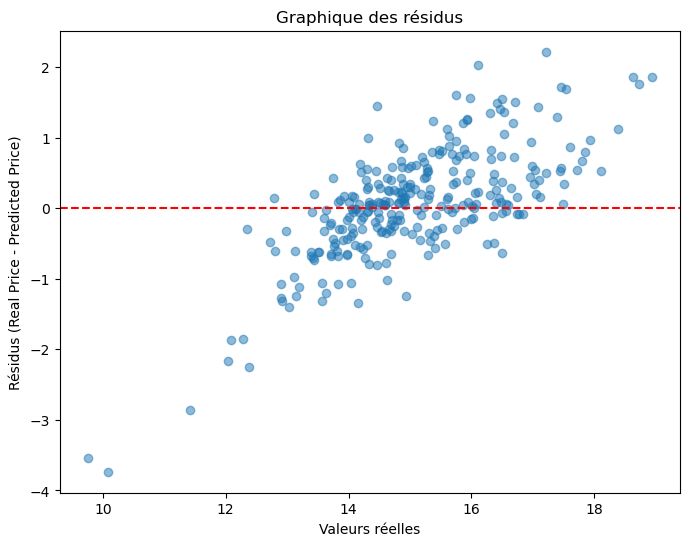

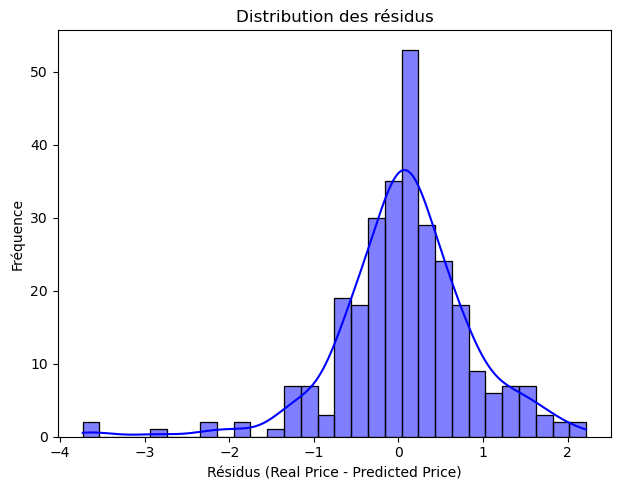

In [238]:
random_search_gradien, results_gradie = hyperparameter_Fonction(pipeline,param_grid,'GradientBoosting', X_train, y_train, X_test, y_test)

On constate que le non utilisation de la caractéristique "ENERGYSTARScore" n'influence pas les résultats de prévision.